In [6]:
from datetime import datetime as dt
import numpy as np
import torch

from matplotlib import pyplot as plt
from torch.utils.data import random_split

from preconditioners import settings
from preconditioners.datasets import generate_true_parameter, CenteredLinearGaussianDataset, generate_true_parameter, generate_c
from preconditioners.utils import MLP, SLP
from preconditioners.optimizers import PrecondGD
import preconditioners


In [7]:
# Same as in linear_kernel_variance_30102022.ipynb (and if it is not, it should be)

from preconditioners.datasets import generate_c, generate_centered_linear_gaussian_data, generate_true_parameter, generate_W_star

def kernel_variance_interpolator(features : np.ndarray, P : np.ndarray, F : np.ndarray, sigma2 : np.float64) -> np.float64:
    ''' Given Nxp feature matrix {features}, pxp symmetric preconditioner P and pxp true covariance matrix F, and the signal to noise ratio, this function returns the variance component of the risk 
    of the interpolator which is the limit of PGD which uses preconditioner P.'''
    assert features.shape[1] == P.shape[0] == P.shape[1] == F.shape[0] == F.shape[1]
    assert np.linalg.norm(P - P.T) < 1e-9, 'P must be symmetric.'

    empirical_NTK = features.dot(P).dot(features.T)
    empirical_NTK_inv = np.linalg.inv(empirical_NTK)
    auxi_matrix = features.dot(P).dot(F).dot(P).dot(features.T)

    return sigma2 * np.trace(empirical_NTK_inv.dot(auxi_matrix).dot(empirical_NTK_inv))

In [8]:
# Adapted CheckEigenvalues class from src/preconditioners/eigenvalues/kernel_eigenvalues.py
# with the linear gaussian dataset

class Initializer:
    def __init__(self,
                width,
                depth,
                d,
                lam,
                train_size,
                extra_size,
                sigma2,
                r2,
                regime,
                ro,
                ):
        # Network parameters
        self.width = width
        self.depth = depth
        self.d = d
        self.damping = lam * np.sqrt(self.d) if self.depth == 1 else lam * self.width

        # Dataset parameters
        self.train_size = train_size
        self.extra_size = extra_size
    
        w_star = generate_true_parameter(self.d, r2, m=np.eye(self.d))
        c = generate_c(ro, regime=regime, d=self.d) if self.depth > 1 else generate_c(ro, regime=regime, d=self.d) * np.sqrt(self.d) # we don't need to multiply by sqrt(d) if d > 1 because there c is not the Fisher
        dataset = CenteredLinearGaussianDataset(w_star, c, n=self.train_size + self.extra_size, d=self.d, sigma2=sigma2)

        self.train_dataset, self.extra_dataset = random_split(dataset, [self.train_size, self.extra_size])
        self.labeled_data = self.train_dataset[:][0].double().to(settings.DEVICE)
        self.unlabeled_data = self.extra_dataset[:][0].double().to(settings.DEVICE)

    def create_model(self):
        std = 1/ np.sqrt(self.width)

        # Create model and optimizer
        if self.depth == 1:
            self.model = SLP(in_channels=self.d).double().to(settings.DEVICE)
        else:
            self.model = MLP(in_channels=self.d, num_layers=self.depth, hidden_channels=self.width, std=std).double().to(settings.DEVICE)
        self.optimizer = PrecondGD(self.model, lr=1e-2, labeled_data=self.labeled_data, unlabeled_data=self.unlabeled_data, verbose=False, damping=self.damping)

    def get_features_and_p_inv(self):
        self.create_model()
        p_inv = self.optimizer._compute_p_inv()
        grad = self.optimizer._compute_grad_of_data(self.labeled_data)
        return grad, p_inv

In [29]:
## Test that I get the same results if the MLP is a linear network.

import random
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

N = 20
sigma2 = 2
ro = 0.9
n_ds = 10
n_lams = 10
ds = [int(x) for x in np.linspace(2*N,65*N,n_ds)]
ams = np.linspace(0.1,10,n_lams)
lams = np.logspace(1, -2, num=n_lams, endpoint=True, base=10.0)

d = 50
lam = 0.1

# linear
damping = lam * np.sqrt(d)
c = np.sqrt(d) * generate_c(ro=ro, regime='autoregressive', d=d)
X = np.random.multivariate_normal(mean=np.zeros(d), cov=c, size=N)
P_damped = np.linalg.inv(c + damping*np.eye(d))
P_ngd = np.linalg.inv(c)

# get it through the initializer
i = Initializer(width = 1,
                depth = 1,
                d = d,
                lam = lam,
                train_size = N,
                extra_size = N+10000,
                sigma2 = sigma2,
                r2 = 1,
                regime = 'autoregressive',
                ro = ro)

grad, F_inv = i.get_features_and_p_inv()

# good enough
print(np.linalg.norm(F_inv - P_damped)/np.sqrt(F_inv.shape[0]))

i = Initializer(width = 1,
                depth = 1,
                d = d,
                lam = lam,
                train_size = N,
                extra_size = N+10000,
                sigma2 = sigma2,
                r2 = 1,
                regime = 'autoregressive',
                ro = ro)

grad_2, F_inv_2 = i.get_features_and_p_inv()

0.01968730569679145


In [30]:
grad[:3,:3]

tensor([[-1.2327, -1.4528, -0.8313],
        [ 2.7773,  3.6217,  4.0523],
        [-2.6389, -2.3438, -1.6241]], dtype=torch.float64)

In [31]:
grad_2[:3,:3]

tensor([[-2.4743, -3.1465, -2.9019],
        [-4.7405, -5.2675, -6.3885],
        [-2.4629, -1.6010,  0.1426]], dtype=torch.float64)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

N = 20
d = 25
sigma2 = 2
ro = 0.9
n_ns = 5
n_lams = 5
variances_damped = np.zeros((n_ns,n_lams))
variances_ngd = np.zeros((n_ns,n_lams))
variances_diff = np.zeros((n_ns,n_lams))    

ns = [int(x) for x in np.linspace(1*N,5*N,n_ns)]
ams = np.linspace(0.1,10,n_lams)
lams = np.logspace(1, -2, num=n_lams, endpoint=True, base=10.0)
dampings = []

k = 0
for i in range(n_ns):
    for j in range(n_lams):
        k = k+1
        print(f'iteration {k} of {n_ns*n_lams}')
        n = ns[i]
        lam = lams[j]
        damping = lam * n # TODO: check if multiplying by n is correct
        dampings.append(damping)
        

        params = {
            'width' : n,
            'depth' : 2,
            'd' : d,
            'lam' : lam,
            'train_size' : N,
            'extra_size' : N+10000,
            'sigma2' : sigma2,
            'r2' : 1,
            'regime' : 'autoregressive',
            'ro' : ro
        }
        i_damped = Initializer(**params)
        grad_damped, p_inv_damped = [x.numpy() for x in i_damped.get_features_and_p_inv()]
        
        params['lam'] = 1e-7 # not zero to avoid division by zero

        i_ngd = Initializer(**params)
        grad_ngd, p_inv_ngd = [x.numpy() for x in i_ngd.get_features_and_p_inv()]

        print(np.linalg.norm(grad_ngd - grad_damped))
        
        # TODO: fix passing F not np.linalg.inv(p_inv_ngd)
        variances_damped[i, j] = kernel_variance_interpolator(features=grad_damped, P=p_inv_damped, F=np.linalg.inv(p_inv_ngd), sigma2=sigma2) 
        variances_ngd[i, j] = kernel_variance_interpolator(features=grad_ngd, P=p_inv_ngd, F=np.linalg.inv(p_inv_ngd), sigma2=sigma2)
        variances_diff = variances_damped - variances_ngd

iteration 1 of 25


/opt/anaconda3/envs/preconditioners_new/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


10.645611388572176
iteration 2 of 25
11.258304248922917
iteration 3 of 25
12.828472675346518
iteration 4 of 25
10.208359836407912
iteration 5 of 25
9.603308043683251
iteration 6 of 25


In [ ]:
grad_ngd

array([[-0.00358468, -0.00322679, -0.01527546, ...,  0.04347398,
        -0.06880903, -0.02245111],
       [ 0.02048103,  0.02853543,  0.02552622, ...,  0.1125819 ,
        -0.2873963 , -0.13746353],
       [-0.00093891,  0.00550843, -0.00034676, ...,  0.05106268,
        -0.03735116, -0.02997937],
       ...,
       [ 0.00709804, -0.00679037, -0.00532483, ...,  0.10206106,
        -0.12350283, -0.10796543],
       [-0.01073396, -0.0128058 , -0.01009348, ...,  0.14142892,
        -0.10394664, -0.09978104],
       [ 0.01853412,  0.01837061,  0.01103577, ...,  0.0870007 ,
        -0.20863698, -0.04940057]])

In [ ]:
grad_damped

array([[-0.00135215, -0.00128608, -0.00149027, ...,  0.01053531,
        -0.1625023 , -0.13515837],
       [ 0.00116638,  0.00056321,  0.0010735 , ..., -0.04372703,
        -0.0445275 , -0.10060484],
       [-0.00127206, -0.0019952 , -0.00158687, ...,  0.1901143 ,
        -0.15624473, -0.16894681],
       ...,
       [-0.00088358, -0.00123894, -0.00070368, ...,  0.04092212,
        -0.09254868, -0.07356246],
       [-0.00232017, -0.00192996, -0.00088767, ..., -0.13793412,
        -0.099516  , -0.14595394],
       [ 0.00121869,  0.00048345, -0.00045415, ...,  0.1264247 ,
        -0.16676855, -0.05046696]])

In [ ]:
lams

array([10.        ,  0.31622777,  0.01      ])

In [ ]:
print(variances_diff[0,:])
print(variances_diff[-1,:])


[ 8.15310612 22.76365907  5.22575163]
[19.91618543 14.08470831 19.2265321 ]


In [ ]:
print(variances_diff[:,0])
print(variances_diff[:,-1])

[ 8.15310612 32.90451908 19.91618543]
[ 5.22575163 10.27530733 19.2265321 ]


<AxesSubplot: >

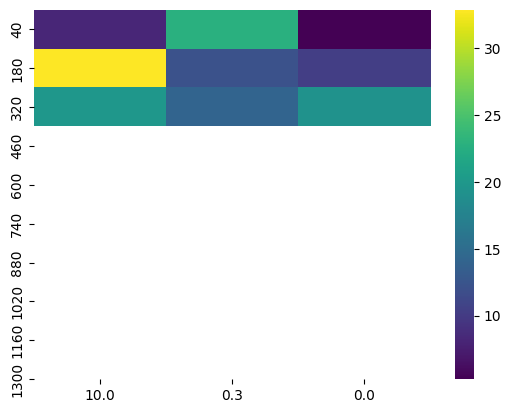

In [ ]:
import seaborn as sns
sns.heatmap(variances_diff, cmap='viridis', xticklabels=[round(x, 1) for x in lams], yticklabels=ds)

In [ ]:
#######################################################################################################
#######################################################################################################


In [61]:
# TODO: Triple check that we are computing the inverse well now and that we were doing it wrong before. Because the tests were passing before.